# Lab 5
> ### Joshua Min (ID: 7926218082, Email: minje@usc.edu)

In [2]:
# Importing required packages
from collections import OrderedDict
from IPython.display import display, Markdown, clear_output
from math import floor, sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import _tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from scipy.io import arff
from scipy.stats import variation
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Part 1 

> Loading and preparing dataset

In [3]:
features1 = [
    'temp',
    'nausea',
    'lumbar_pain',
    'urine_pushing',
    'micturition_pains',
    'burning',
]
labels1 = [
    'inflammation',
    'nephritis'
] 
df1 = pd.read_csv(
    './data/diagnosis.data',
    sep='\t',
    encoding='utf-16',
    header=None,
    names=(features1 + labels1)
)

# Convert string data for temperature into floating-point numbers
df1['temp'] = [i.replace(',', '.') for i in df1['temp']]

# Encode remaining binary qualitative features as 0 or 1
for feature in features1 + labels1:
    if feature is 'temp':
        continue
    df1[feature] = df1[feature].map({'yes': 1, 'no': 0})

# Separate labels from features
X = df1.drop(['inflammation', 'nephritis'], axis=1)
y = df1[['inflammation', 'nephritis']]

> Building and plotting decision tree (multi-label method as opposed to label-powerset)

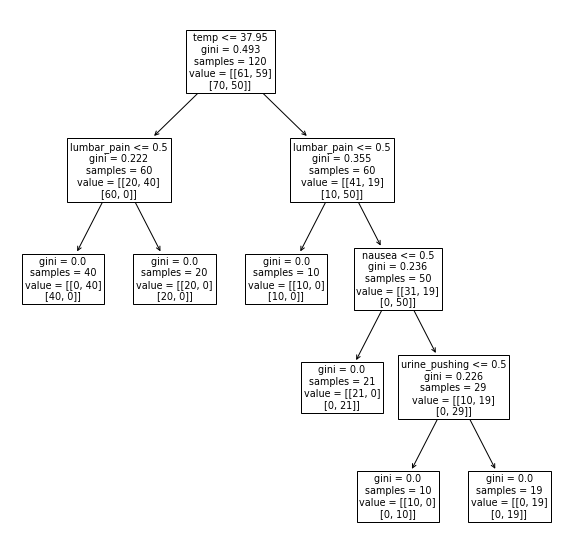

In [4]:
model = tree.DecisionTreeClassifier()
clf = model.fit(X, y)
plt.figure(figsize=(10,10))
tree.plot_tree(clf, feature_names=features1, class_names=labels1)
print()

> Helper function to represent tree as *if-then* rules
> Found on https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

In [5]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)

> Tree represented as *if-then* rules

In [6]:
tree_to_code(clf, features1)

tree(temp, nausea, lumbar_pain, urine_pushing, micturition_pains, burning):
  if temp <= 37.95000076293945:
    if lumbar_pain <= 0.5:
      return [[ 0. 40.]
 [40.  0.]]
    else:  # if lumbar_pain > 0.5
      return [[20.  0.]
 [20.  0.]]
  else:  # if temp > 37.95000076293945
    if lumbar_pain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if lumbar_pain > 0.5
      if nausea <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if nausea > 0.5
        if urine_pushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if urine_pushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


## Part 2

> Loading and preparing the dataset

In [7]:
# Get column names from arff header
cols2 = arff.loadarff('./data/communities.cols')
cols2 = pd.DataFrame(cols2[0])
cols2 = list(cols2.columns)

# Load dataset 
df2 = pd.read_csv('./data/communities.data', names=cols2)

# Impute missing values using median
df2[cols2] = df2[cols2].replace('?', np.NaN)
df2.fillna(df2.median(), inplace=True)

# Drop non-predictive features
non_predictive = ['state', 'county', 'community', 'communityname', 'fold']
cols2 = list(set(cols2) - set(non_predictive))
df2 = df2.drop(non_predictive, axis=1)

# "Goal predictor from dataset"
goal = 'ViolentCrimesPerPop'
features2 = list(set(cols2) - set([goal]))
labels2 = [goal]

# Split data into train and test sets
train_data = df2[:1495]
test_data = df2[1495:]

> Plotting correlation matrix for the features in the dataset

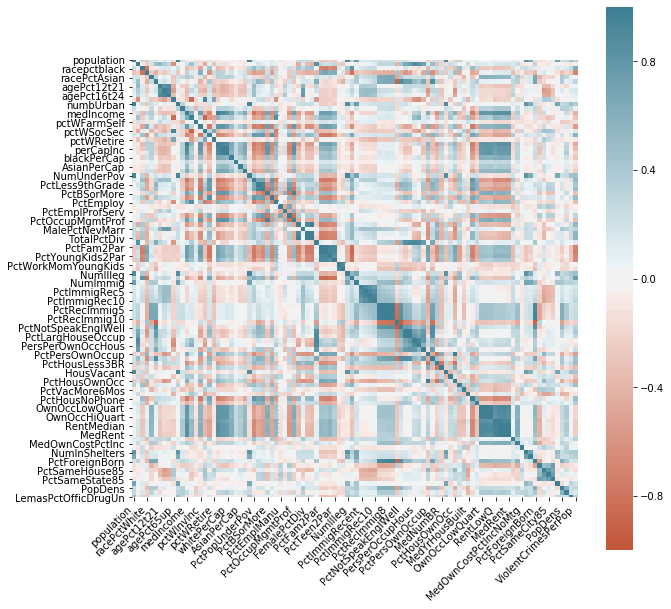

In [8]:
corr = df2.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

> Calculating the CV of each feature and selecting the floor(sqrt(122)) of those with the highest CV

In [9]:
feature_cvs = []
for feature in features2:
    feature_cvs.append({
        'feature': feature,
        'cv': variation(df2[feature].astype(float))
    })


feature_cvs.sort(key=lambda x: x['cv'], reverse=True)
highest_cvs = [x['feature'] for x in feature_cvs[:floor(sqrt(122))]]

> Making scatter and box-plots for the floor(sqrt(128)) features with the highest CV

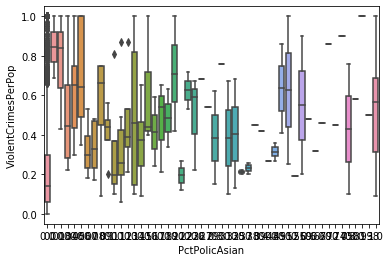

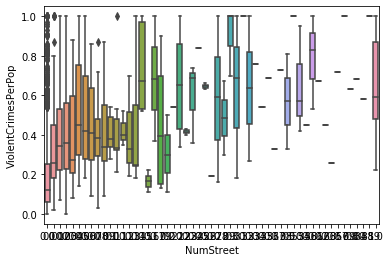

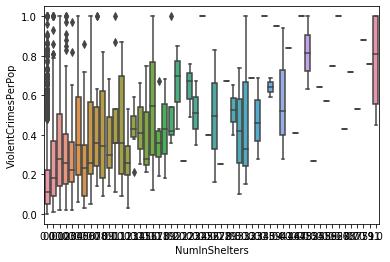

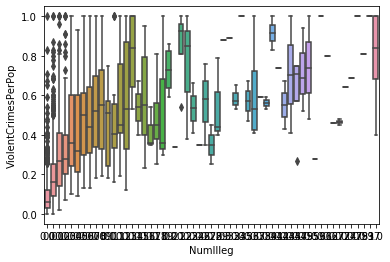

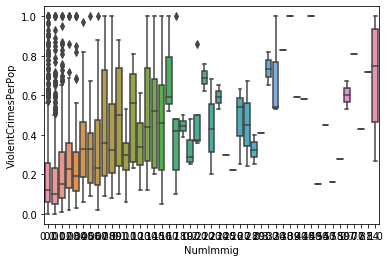

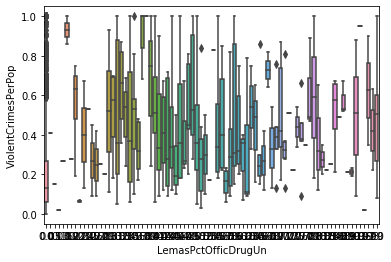

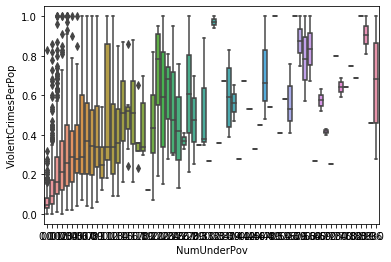

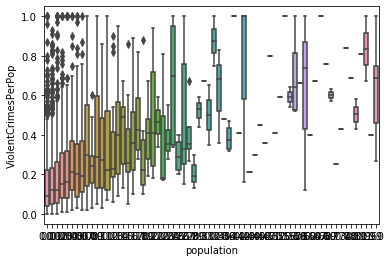

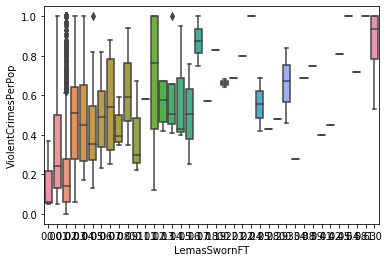

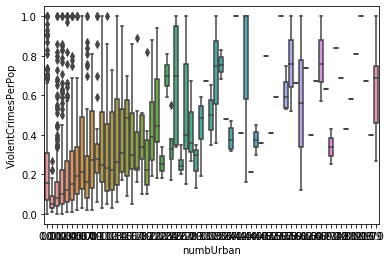

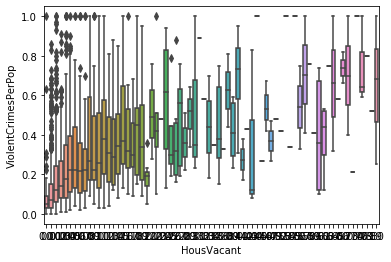

In [10]:
for (i, feature) in enumerate(highest_cvs):
    plt.figure(i)
    sns.boxplot(
        x=df2[feature].astype(float),
        y=df2[goal].astype(float)
    )

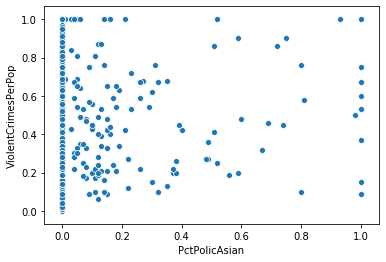

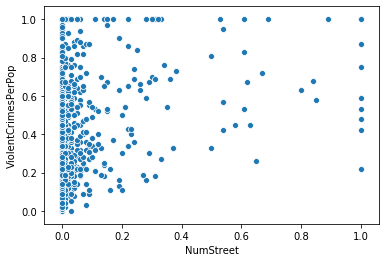

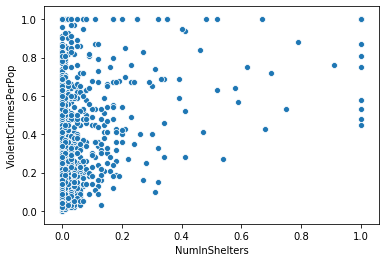

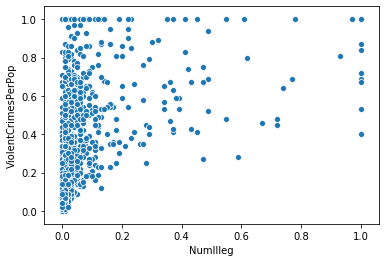

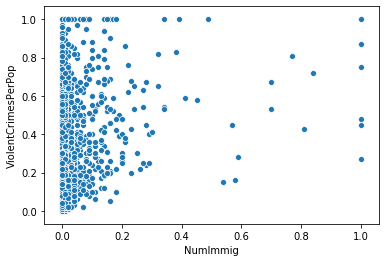

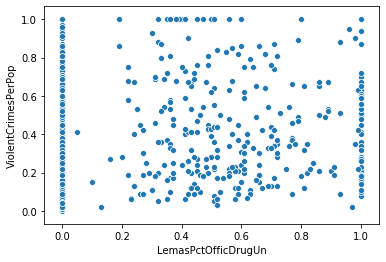

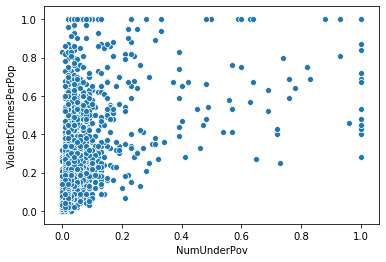

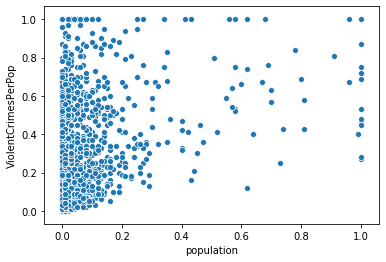

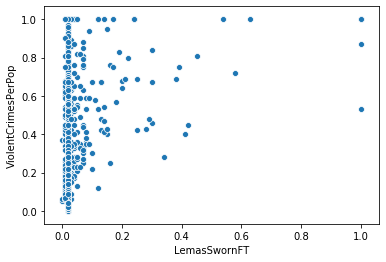

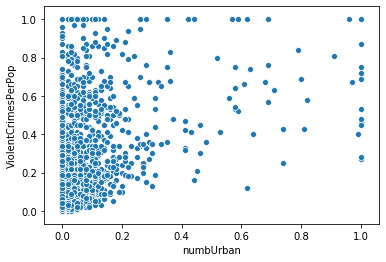

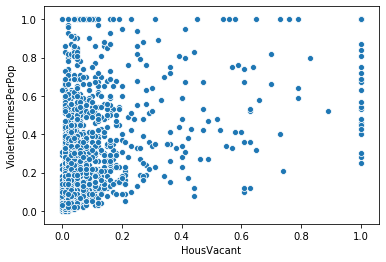

In [11]:
for (i, feature) in enumerate(highest_cvs):
    plt.figure(i)
    sns.scatterplot(
        x=df2[feature].astype(float),
        y=df2[goal].astype(float)
    )

> No, we cannot draw conclusions about the significance of these features just by the scatter plots. All of the pictured features have extremely high variance with respect to the "goal" feature ViolentCrimesPerPop.

> Fitting a linear model to training set using least squares

In [17]:
test_features = test_data[features2]
test_labels = test_data[goal]
lin_clf = LinearRegression().fit(train_data[features2], train_data[goal])
lin_pred = lin_clf.predict(test_features)
lin_test_err = mean_squared_error(test_data[goal], lin_pred)
display(Markdown("**LinReg Test MSE: {}**".format(lin_test_err)))

**LinReg Test MSE: 4.648713507763623e+18**

> Fitting a ridge regression model to training set using 5-fold CV

In [18]:
ridge_clf = RidgeCV(cv=5).fit(train_data[features2], train_data[goal])
ridge_pred = ridge_clf.predict(test_features)
ridge_test_err = mean_squared_error(test_labels, ridge_pred)
display(Markdown("**Ridge Test MSE: {}**".format(ridge_test_err)))

**Ridge Test MSE: 0.017630963071705724**

> Fitting a LASSO model to training set using 5-fold CV

In [20]:
lasso_clf = LassoCV(cv=5).fit(train_data[features2], train_data[goal])
lasso_pred = lasso_clf.predict(test_data[features2])
lasso_test_err = mean_squared_error(test_labels, lasso_pred)
display(Markdown("**LASSO Test MSE: {}**".format(lasso_test_err)))

**LASSO Test Error Rate: 0.01761864507595973**

> Repeating the above using standardized features

In [22]:
X_scaled = preprocessing.scale(train_data[features2])
test_X_scaled = preprocessing.scale(test_data[features2])
lasso_clf = LassoCV(cv=5).fit(X_scaled, train_data[goal])
lasso_pred = lasso_clf.predict(test_X_scaled)
lasso_test_err = mean_squared_error(test_labels, lasso_pred)
display(Markdown("**LASSO (Standardized) MSE: {}**".format(lasso_test_err)))

**LASSO (Standardized) MSE: 0.0178723247145162**

> Instantiating the two Random Forest models

In [30]:
# This can take a long time
min_err = 1000000
min_err_tree = None
MIN_B = 1
MAX_B = 300
rf_clfs = [
    [
        (
            "m=floor(sqrt(122))",
            RandomForestRegressor(
                n_jobs=-1,
                n_estimators=b,
                max_features='sqrt',
                oob_score=True,
                warm_start=True
            )
        ),
        (
            "m=122",
            RandomForestRegressor(
                n_jobs=8,
                n_estimators=b,
                max_features=None,
                oob_score=True,
                warm_start=True
            )
        )
    ] for b in range(MIN_B, MAX_B, 1)
]

# Create data structure to store errors
errors = {
    "m=floor(sqrt(122))": {
        "train": [],
        "test": [],
        "oob": []
    },
    "m=122": {
        "train": [],
        "test": [],
        "oob": []
    }
}

# Loop over all B -> {1, ..., 300} and create models for:
# m=122
# m=floor(sqrt(122))
# 
# NOTE: I use 122 here because of the 5 non-predictive features that we took out
#       as well as the goal label
for (b, clfs) in enumerate(rf_clfs):
    clear_output(wait=True)
    for (label, clf) in clfs:
        rf = clf.fit(train_data[features2], train_data[goal])
        train_pred = rf.predict(train_data[features2])
        train_err = mean_squared_error(train_data[goal], train_pred)
        test_pred = rf.predict(test_data[features2])
        test_err = mean_squared_error(test_data[goal], test_pred)
        oob_err = 1 - rf.oob_score_
        if test_err < min_err:
            min_err = test_err
            min_err_tree = rf
        errors[label]["train"].append(train_err)
        errors[label]["test"].append(test_err)
        errors[label]["oob"].append(oob_err)
    print("Progress:", np.round(b/len(rf_clfs) * 100, 2), "%")
clear_output(wait=True)

Progress: 99.67 %


> Plotting Results for Random Forests

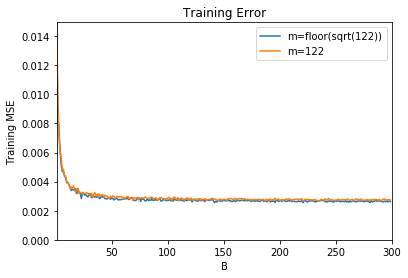

In [31]:
# Plotting training errors from the data stored in the previous data struct
for label in errors:
    xs = [i for i in range(MIN_B, MAX_B, 1)]
    ys = errors[label]['train']
    plt.plot(xs, ys, label=label)

plt.title('Training Error')
plt.xlim(MIN_B, MAX_B)
plt.ylim(0, max(ys))
plt.xlabel("B")
plt.ylabel("Training MSE")
plt.legend(loc="upper right")
plt.show()

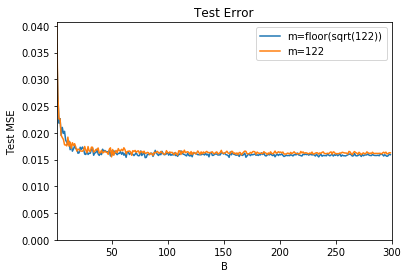

In [32]:
# Plotting training errors from the data stored in the previous data struct
for label in errors:
    xs = [i for i in range(MIN_B, MAX_B, 1)]
    ys = errors[label]['test']
    plt.plot(xs, ys, label=label)

plt.title('Test Error')
plt.xlim(MIN_B, MAX_B)
plt.ylim(0, max(ys))
plt.xlabel("B")
plt.ylabel("Test MSE")
plt.legend(loc="upper right")
plt.show()

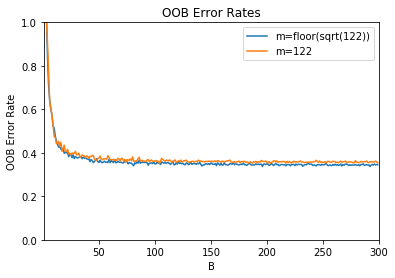

In [33]:
for label in errors:
    xs = [i for i in range(MIN_B, MAX_B, 1)]
    ys = errors[label]['oob']
    plt.plot(xs, ys, label=label)

plt.title('OOB Error Rates')
plt.xlim(MIN_B, MAX_B)
plt.ylim(0, 1)
plt.xlabel("B")
plt.ylabel("OOB Error Rate")
plt.legend(loc="upper right")
plt.show()

> Variable Importance Plot

Feature ranking:
1. feature NumIlleg(0.092739)
2. feature PctSpeakEnglOnly(0.068304)
3. feature PctImmigRec5(0.051376)
4. feature PersPerFam(0.050069)
5. feature PctImmigRecent(0.049586)
6. feature PctPolicHisp(0.034117)
7. feature PctSameState85(0.031478)
8. feature PctYoungKids2Par(0.028184)
9. feature indianPerCap(0.027718)


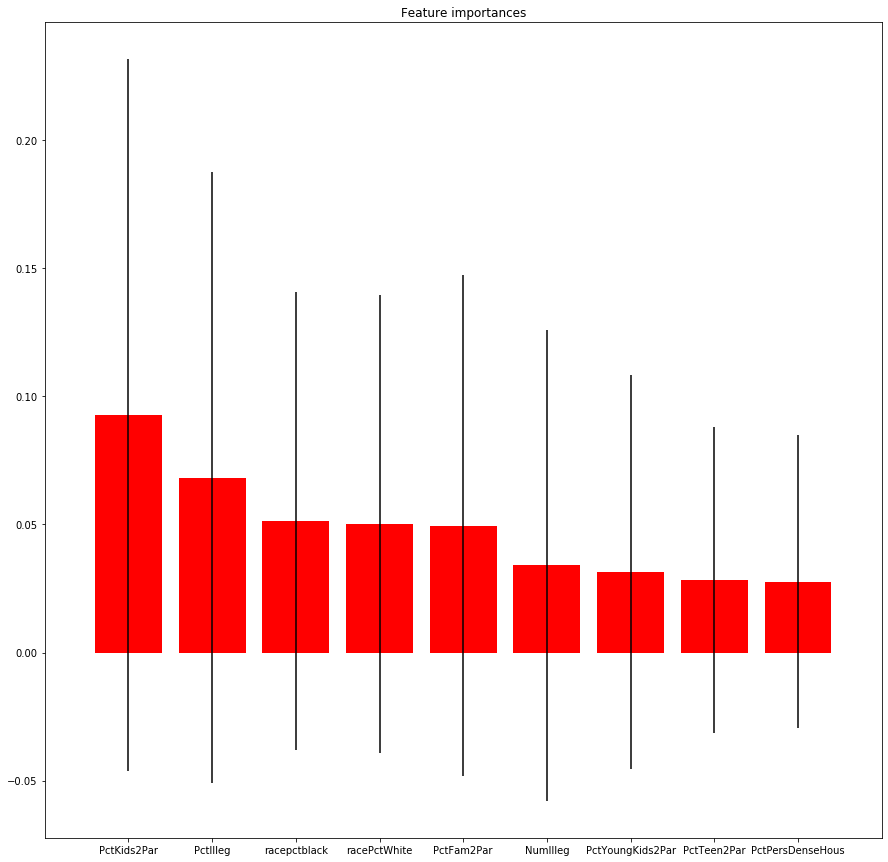

In [34]:
forest = min_err_tree
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(9):
    print("%d. feature %s(%f)" % (f + 1, features2[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(9), importances[indices[:9]],
       color="r", yerr=std[indices[:9]], align="center")
plt.xticks(range(9), [features2[i] for i in indices[:9]])
plt.xlim([-1, 9])
plt.show()

> Instantiating the Extra Trees models

In [ ]:
min_err = 1000000
min_err_tree = None

rf_clfs2 = [
    [
        (
            "m=floor(sqrt(122))",
            ExtraTreesRegressor(
                n_jobs=8,
                n_estimators=b,
                max_features=floor(sqrt(122)),
                oob_score=True,
                warm_start=True,
                bootstrap=True
            )
        ),
        (
            "m=122",
            ExtraTreesRegressor(
                n_jobs=8,
                n_estimators=b,
                max_features=122,
                oob_score=True,
                warm_start=True,
                bootstrap=True
            )
        )
    ] for b in range(MIN_B, MAX_B, 1)
]

errors2 = {
    "m=floor(sqrt(122))": {
        "train": [],
        "test": [],
        "oob": []
    },
    "m=122": {
        "train": [],
        "test": [],
        "oob": []
    }
}

for (b, clfs) in enumerate(rf_clfs2):
    clear_output(wait=True)
    for (label, clf) in clfs:
        rf = clf.fit(train_data[features2], train_data[goal])
        
        train_pred = rf.predict(train_data[features2])
        train_err = mean_squared_error(train_data[goal], train_pred)
        
        test_pred = rf.predict(test_data[features2])
        test_err = mean_squared_error(test_data[goal], test_pred)
        
        oob_err = 1 - rf.oob_score_
        
        if test_err < min_err:
            min_err = test_err
            min_err_tree = rf
        errors2[label]["train"].append(train_err)
        errors2[label]["test"].append(test_err)
        errors2[label]["oob"].append(oob_err)
    print("Progress:", np.round(b/len(rf_clfs) * 100, 2), "%")

Progress: 89.97 %


> Plotting Results for Extra Trees

In [ ]:
for label in errors2:
    xs = [i for i in range(MIN_B, MAX_B, 1)]
    ys = errors2[label]['train']
    plt.plot(xs, ys, label=label)

plt.title('Training Error')
plt.xlim(MIN_B, MAX_B)
plt.ylim(0, max(ys))
plt.xlabel("B")
plt.ylabel("Training MSE")
plt.legend(loc="upper right")
plt.show()

In [ ]:
for label in errors2:
    xs = [i for i in range(MIN_B, MAX_B, 1)]
    ys = errors2[label]['test']
    plt.plot(xs, ys, label=label)

plt.title('Test Error')
plt.xlim(MIN_B, MAX_B)
plt.ylim(0, max(ys))
plt.xlabel("B")
plt.ylabel("Test MSE")
plt.legend(loc="upper right")
plt.show()

In [ ]:
for label in errors2:
    xs = [i for i in range(MIN_B, MAX_B, 1)]
    ys = errors2[label]['oob']
    plt.plot(xs, ys, label=label)

plt.title('OOB Error')
plt.xlim(MIN_B, MAX_B)
plt.ylim(0, max(ys))
plt.xlabel("B")
plt.ylabel("OOB Error Rate")
plt.legend(loc="upper right")
plt.show()

> Variable Importance for Extra Trees

In [ ]:
forest = min_err_tree
forest.fit(train_data[features2], train_data[goal])
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(9):
    print("%d. feature %s(%f)" % (f + 1, features2[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(9), importances[indices[:9]],
       color="r", yerr=std[indices[:9]], align="center")
plt.xticks(range(9), [features2[i] for i in indices[:9]])
plt.xlim([-1, 9])
plt.show()